## Super Agent: Integrating Autogen Technologies and Vector Databases

The Super Agent project showcases the integration of cutting-edge technologies including Ollama, LiteLLM, Autogen, LanceDB, and LangChain to create a powerful AI agent. This agent leverages the strengths of vector databases and conversational AI to provide sophisticated data management and context-aware interactions. The goal is to harness the capabilities of LanceDB's vector database and Autogen's conversational AI framework to build a Super Agent that excels in understanding and processing complex queries.

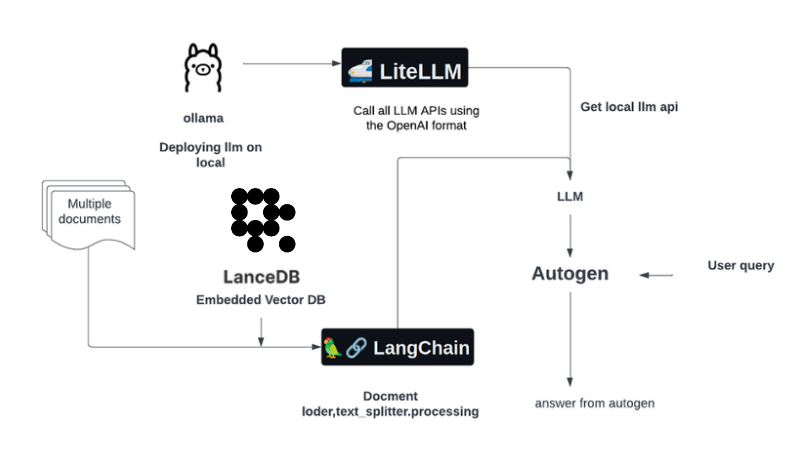

This notebook  illustrates how you can use the Langchain with custom PDF data & chat it using an Autogen Agent.

In [1]:
%pip install ag2~=0.1.0  langchain langchain_community openai tiktoken lancedb pypdf -q -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00


In [5]:
from langchain_community.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.memory import ConversationBufferMemory
from langchain_community.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain_community.vectorstores import LanceDB

Requirements
AutoGen requires Python>=3.8.

To run this notebook example, please install `ag2`:


In [3]:
!pip install ag2

### Add OpenAI API key as env variable

In [6]:
import lancedb
import os

# setup OPENAI API KEY
os.environ["OPENAI_API_KEY"] = "sk-proj-....."

# initiate OPENAI Embedding function
embeddings = OpenAIEmbeddings()

### Import data

This example utilizes "Food and Nutrition handbook by MINISTRY OF AGRICULTURE, ANIMAL INDUSTRY AND FISHERIES" PDF which is imported from following code.

In [8]:
# !wget -O uniswap_v3.pdf https://uniswap.org/whitepaper-v3.pdf
!wget -O food.pdf https://pdf.usaid.gov/pdf_docs/PA00TBCT.pdf

--2024-12-04 18:08:56--  https://pdf.usaid.gov/pdf_docs/PA00TBCT.pdf
Resolving pdf.usaid.gov (pdf.usaid.gov)... 23.54.221.184, 2600:1408:c400:1687::1923, 2600:1408:c400:1697::1923
Connecting to pdf.usaid.gov (pdf.usaid.gov)|23.54.221.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6419525 (6.1M) [application/pdf]
Saving to: ‘food.pdf’

food.pdf            100%[===================>]   6.12M  --.-KB/s    in 0.08s   

2024-12-04 18:08:56 (74.1 MB/s) - ‘food.pdf’ saved [6419525/6419525]



# create file name with OAI_CONFIG_LIT.json

In [12]:
# create file name with OAI_CONFIG_LIT.
import json

config = [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]

with open("OAI_CONFIG_LIST.json", "w") as fp:
    json.dump(config, fp)

**create OAI_CONFIG_LIST.json file in pwd & upload
in it**


[
   {
     "model": "gpt-4",
     "api_key": "sk-yourapikey"
   }
]

In [13]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
    filter_dict={
        "model": ["gpt-4"],
    },
)

In [14]:
# load imported dataset in PDF loader and split them in chunks
loaders = [PyPDFLoader("./food.pdf")]
docs = []
for l in loaders:
    docs.extend(l.load())
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000)
docs = text_splitter.split_documents(docs)

In [15]:
import lancedb

embeddings = OpenAIEmbeddings()
# initiate LanceDB and ingest the splited chunks into it
vectorstore = LanceDB.from_documents(documents=docs, embedding=embeddings)

In [16]:
# define a retrieval chain to start chatting with ingested data
qa = ConversationalRetrievalChain.from_llm(
    OpenAI(
        temperature=0,
    ),
    vectorstore.as_retriever(),
    memory=ConversationBufferMemory(memory_key="chat_history", return_messages=True),
)

<ipython-input-16-70ff1d5b784c>:3: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  OpenAI(
<ipython-input-16-70ff1d5b784c>:7: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory=ConversationBufferMemory(memory_key="chat_history", return_messages=True),


### Start Querying

Now we are ready to start query and get answers

In [17]:
# helper function to return responses in the form of answer of queries
def answer_food_question(question):
    response = qa({"question": question})
    return response["answer"]

In [18]:
# query
question = "what is good food"
answer_food_question(question)

<ipython-input-17-e9499bd82ace>:3: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa({"question": question})


' Good food is food that provides the recommended amounts of nutrients for the body to perform all its physiological activities. It is important to eat the right types of food, in the right amounts, at the right time, and prepared in the correct way and place. Good food is essential for physical and cognitive development, and it can improve overall health and quality of life.'

### Autogen

Now lets try to go same using Autogen

In [21]:
# install autogen
!pip install ag2 -q

#### Set up AutoGen user agent and assistant agent with function calling enabled.

In [20]:
llm_config = {
    "request_timeout": 600,
    "seed": 42,
    "config_list": config_list,
    "temperature": 0,
    "functions": [
        {
            "name": "answer_food_question",
            "description": "Answer to any quetion related to food & provided answer_food_question ",
            "parameters": {
                "type": "object",
                "properties": {
                    "question": {
                        "type": "string",
                        "description": "The question to ask in relation to food",
                    }
                },
                "required": ["question"],
            },
        }
    ],
}

In [22]:
# create an AssistantAgent instance named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config=llm_config,
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={"work_dir": "."},
    llm_config=llm_config,
    system_message="""Reply TERMINATE if the task has been solved at full satisfaction.
Otherwise, reply CONTINUE, or the reason why the task is not solved yet.""",
    function_map={"answer_food_question": answer_food_question},
)

In [23]:
# the assistant receives a message from the user, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""
what is good food?
""",
)

user_proxy (to assistant):


what is good food?


--------------------------------------------------------------------------------
assistant (to user_proxy):

***** Suggested function Call: answer_food_question *****
Arguments: 
{
  "question": "what is good food?"
}
*********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION answer_food_question...
user_proxy (to assistant):

***** Response from calling function "answer_food_question" *****
 Good food is any type of liquid, semi-solid, or solid substance that contains nutrients and nourishes the body when consumed. It is important because it provides the body with essential nutrients, promotes good health, and helps prevent illnesses and health problems. Good food should be eaten in appropriate amounts, at the right time, and prepared correctly to ensure a balanced diet. It should also include a variety of foods from each food 

In [24]:
# the assistant receives a message from the user, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""
please explain me essential minerals, sources, functions and symptoms of
deficiency?
""",
)

user_proxy (to assistant):


please explain me essential minerals, sources, functions and symptoms of
deficiency?


--------------------------------------------------------------------------------
assistant (to user_proxy):

Sure, here are some essential minerals, their sources, functions, and symptoms of deficiency:

1. Calcium:
   - Sources: Dairy products, leafy green vegetables, fish with edible bones (like sardines and salmon), fortified foods.
   - Functions: Necessary for bone health, muscle function, nerve transmission, blood clotting.
   - Deficiency Symptoms: Osteoporosis, muscle cramps, dental problems, brittle nails.

2. Iron:
   - Sources: Red meat, poultry, eggs, fruits, green vegetables, fortified bread.
   - Functions: Essential for the production of red blood cells, carries oxygen in the blood.
   - Deficiency Symptoms: Anemia, fatigue, weakness, pale skin, shortness of breath.

3. Potassium:
   - Sources: Bananas, oranges, cantaloupes, raisins, nuts, fish, and whole g

In [25]:
# the assistant receives a message from the user, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""
which food Keeps eyes healthy ?
""",
)

user_proxy (to assistant):


which food Keeps eyes healthy ?


--------------------------------------------------------------------------------
assistant (to user_proxy):

***** Suggested function Call: answer_food_question *****
Arguments: 

{
  "question": "which food Keeps eyes healthy ?"
}
*********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION answer_food_question...
user_proxy (to assistant):

***** Response from calling function "answer_food_question" *****
 Foods rich in Vitamin A, such as liver, egg yolk, dairy products, and dark green and deep yellow fruits and vegetables, can help maintain healthy eyes.
*****************************************************************

--------------------------------------------------------------------------------
assistant (to user_proxy):

Foods that are rich in Vitamin A can help maintain healthy eyes. These include:

1. Liver